주어진 데이터셋을 차원 축소한 뒤 **다양한 알고리즘**을 적용하여 클러스터링을 진행하고, 결과를 시각화하는 작업을 직접 해보면서 **비지도학습** (Unsupervised Learning)에 대한 이해도를 높여 봅시다.

In [64]:
## 필요한 라이브러리를 임포트합니다.

import pandas as pd
import numpy as np

In [65]:
## 시각화 관련 라이브러리를 임포트합니다.

from matplotlib import pyplot as plt
import seaborn as sns

###데이터

사용할 데이터: 'Marketing Campaign.csv'

주어진 데이터는 마케팅 캠페인을 펼치고자 하는 소비자들에 대한 정보를 나타낸 데이터입니다. 해당 소비자들을 알맞게 군집화시키는 것이 우리의 목적입니다.

총 29개의 column으로 구성되어 있습니다. 



---







데이터에 대한 자세한 설명은 해당 kaggle 페이지에서 확인하실 수 있습니다.

https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

데이터를 불러옵니다.

In [ ]:
## drive에 있는 데이터셋을 불러오기 위해 드라이브와 연동을 합니다.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
## 'Marketing_campaign' 데이터의 위치를 불러와 저장합니다.

data = pd.read_csv('marketing_campaign.csv', \
                   sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [67]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

### 데이터 전처리

In [68]:
## 등록한 이후에 현재까지의 기간(회원 일수)를 'days'라는 변수로 저장.
from datetime import datetime
y = pd.to_datetime(datetime.today().strftime("%Y-%m-%d")) #datetime 타입으로 변환

data.Dt_Customer = pd.to_datetime(data.Dt_Customer) #datetime 타입으로 변환
data['days'] = y - data.Dt_Customer
data['days'] = data['days'] / np.timedelta64(1, 'D')
data['days'] = data['days'].astype('int')
data['days'][:5]

0    3814
1    3264
2    3463
3    3290
4    3312
Name: days, dtype: int32

In [69]:
## 나이를 age에 저장
data['age'] = 2024-data['Year_Birth']

In [70]:
## 마케팅 캠페인에서의 총 참여 횟수
data['CampaignAttendance'] = data.iloc[:,20:25].sum(axis=1)

## 이 데이터랑 군집화 결과가 얼마나 유사하게, 또는 다르게 나오는지 비교해봅시다~!!

In [71]:
data.columns

features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',\
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',\
                    'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response','CampaignAttendance'] #우리가 고려할 변수들

In [72]:
X_features = data[features]
X_features = X_features.dropna().reset_index(drop = True) #결측치 제거

y_label = X_features['CampaignAttendance'] #캠페인에서의 총 참여 횟수를 임의의 라벨값으로 설정 -> 기준으로 삼아보자.

X_features = X_features.drop(['CampaignAttendance'], axis = 1)

In [73]:
## 각 변수들을 '표준화' scaling 합니다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_features_scaling  = scaler.fit_transform(X_features)

X_features_scaling = pd.DataFrame(X_features_scaling, columns = X_features.columns, index = list(X_features.index.values))

###차원 축소

데이터를 차원 축소 해봅시다.

In [74]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## LDA
lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_features_scaling, y_label) #차원축소 과정에 y 라벨값을 입력해줌

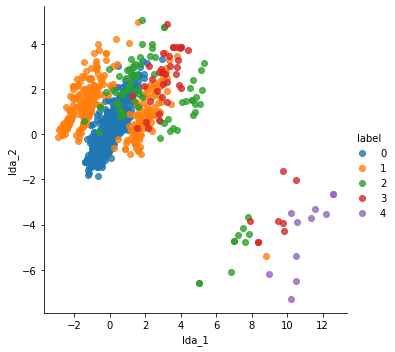

In [75]:
X_train_lda = pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda = pd.concat((X_train_lda, y_label), axis = 1) #X_train_Ida와 y_label 데이터를 하나로 합치기
X_train_lda.columns = ['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x = 'lda_1',y = 'lda_2',data = X_train_lda, hue = 'label', fit_reg = False)
plt.show()

## 우리가 원하는 정답 모양
## 캠페인 참여에서의 총 참여 횟수를 라벨값으로 둔 상태에서의 데이터 분포도

###K-means Clustering

클러스터링을 돌려 보는 데에 의의가 있기에, 파라미터 값 최적화보다는 각 알고리즘을 사용하면 결과가 어떻게 달라지는 지에 초점을 맞추어 살펴봅니다. 여러 번 시행해보면서 **자유롭게 파라미터를 정해주세요**.

**(직접 최적의 파라미터 값을 찾아서 설정하고 싶으시다면 훨씬 좋습니다! 해당 과제의 모든 코드는 기본 뼈대일 뿐입니다. 코드를 추가 또는 변경하셔도 좋습니다.)**

다른 x값들에 대해서도 캠페인 참여도, 즉 고객의 충실도를 잘 군집화할 수 있을까요? 클러스터링으로 결과를 확인해봅시다.



---





K-means를 이용하여 클러스터링 해봅시다.

In [76]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import KMeans

In [77]:
## 클러스터 수는 ########(숫자)########로 설정하고, KMeans를 활용하여 예측된 y값을 만들어 봅시다.

km = KMeans(n_clusters = 4)

y_km = km.fit_predict(X_features_scaling)
y_km

array([0, 2, 0, ..., 1, 0, 2])

In [78]:
X_train_lda['K_means'] = y_km

####시각화

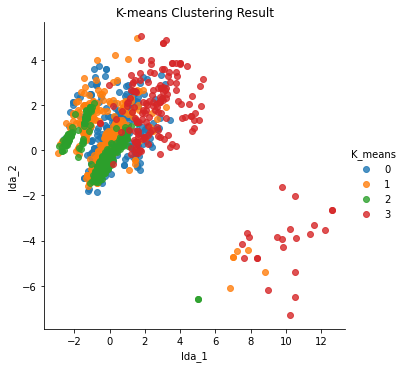

In [79]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

###Hierarchical Clustering

Agglomerative 방법을 이용하여 클러스터링 해봅시다.

In [80]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import AgglomerativeClustering

In [81]:
## 클러스터 수는 ########(숫자)########로 설정하고, Agglomerative를 활용하여 예측된 y값을 만들어 봅시다.

agghc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward') #와드연결법을 사용합니다.

y_agghc = agghc.fit_predict(X_features_scaling)
y_agghc

array([2, 3, 2, ..., 0, 2, 0], dtype=int64)

In [82]:
X_train_lda['hierarchical'] = y_agghc

####시각화

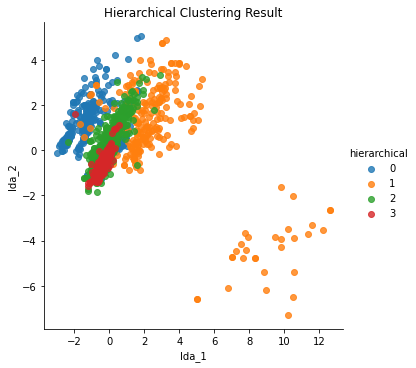

In [83]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'hierarchical', fit_reg = False)
plt.title('Hierarchical Clustering Result')
plt.show()

###DBSCAN

DBSCAN을 이용하여 클러스터링 해봅시다.

In [84]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import DBSCAN

In [85]:
from sklearn.cluster import DBSCAN
import sklearn.utils
import sklearn.neighbors
from sklearn.neighbors import NearestNeighbors

In [101]:
X_features_scaling

,days,age,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1.529129,0.986443,0.234063,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,...,0.693232,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,2.377952
1,-1.188411,1.236801,-0.234559,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
2,-0.205155,0.318822,0.769478,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,...,-0.543978,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
3,-1.059945,-1.266777,-1.017239,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,...,0.280829,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
4,-0.951244,-1.016420,0.240221,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,0.135772,0.151917,0.356642,-0.104093,1.197646,0.418348,0.066913,0.079693,2.215416,3.919308,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
2212,-1.652863,1.904422,0.467539,0.241428,0.299208,-0.662463,-0.610954,-0.687574,-0.658233,-0.694260,...,0.693232,-0.281773,-0.282705,-0.280839,3.821732,-0.117148,-0.097812,0.0,0.0,-0.420530
2213,-0.980889,-1.016420,0.188091,1.450751,1.787710,0.544024,0.223001,-0.102990,-0.365998,-0.385402,...,0.280829,-0.281773,3.537258,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
2214,-0.975948,1.069896,0.675388,-1.417072,0.364441,0.091591,0.209622,0.773887,0.072356,0.328832,...,-0.956381,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530


In [102]:
nb = NearestNeighbors(n_neighbors = 4).fit(X_features_scaling)

In [103]:
minPts = 4

In [104]:
distances, indices = nb.kneighbors(X_features_scaling)

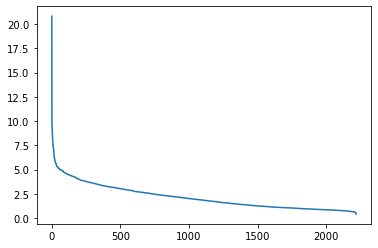

In [109]:
distance = sorted(distances[:, minPts-1], reverse = True)
plt.plot(list(range(1,2217)), distance)
#6.0정도에서 꺾이는 것을 확인 가능 =>eps=6

In [111]:
## eps는 ########(숫자)########, minPts는 ########(숫자)########로 설정한 뒤 DBSCAN를 활용하여 예측된 y값을 만들어 봅시다.

dbscan = DBSCAN(eps = 6 , min_samples = 4, metric = 'euclidean') #eps는 0-1

y_dbscan = dbscan.fit_predict(X_features_scaling)
y_dbscan

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [112]:
X_train_lda['dbscan'] = y_dbscan

####시각화

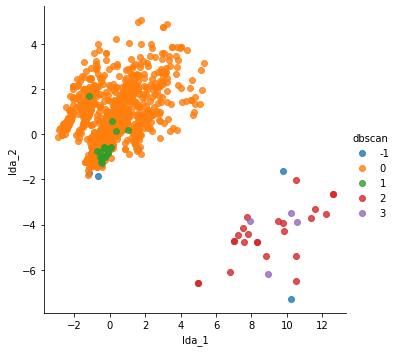

In [113]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'dbscan', fit_reg = False)
plt.show()

###Validation

실루엣 계수를 사용하여 각 클러스터링의 성능을 평가해봅시다.



---



(Q) 실루엣 계수로 평가하기 전에, 육안 상으로 어떠한 알고리즘의 성능이 제일 높아 보이며 어떠한 알고리즘의 성능이 제일 낮아 보이는지 의견을 적어주세요.

육안 상으로는 K-means clustering의 성능이 제일 낮아보이고 Hierarchical Clustering의 성능이 가장 높은 것처럼 보인다.



---



이제 실루엣 계수로 성능을 평가해 봅시다!

In [114]:
## 필요한 라이브러리를 임포트합니다.

import sklearn.metrics as metrics
from sklearn.metrics.cluster import silhouette_score

K-means Clustering의 실루엣 계수입니다.

In [115]:
coef_km = metrics.silhouette_score(X_features_scaling, y_km)
print('Silhouette score is {}.'.format(coef_km))

Silhouette score is 0.19062058158068393.


Hierarchical Clustering의 실루엣 계수입니다.

In [116]:
## Hierarchical Clustering

coef_hc = metrics.silhouette_score(X_features_scaling, y_agghc)
print('Silhouette score is {}.'.format(coef_hc))

Silhouette score is 0.17142231156823046.


DBSCAN의 실루엣 계수입니다.

In [119]:
## DBSCAN

coef_db = metrics.silhouette_score(X_features_scaling, y_dbscan)
print('Silhouette score is {}.'.format(coef_db))

Silhouette score is 0.48936194362599106.


(Q) 실루엣 계수를 기반으로, 클러스터링 알고리즘의 성능을 높은 순대로 적어주세요.

실루엣 계수가 클수록 클러스터링 알고리즘의 성능이 높다고 볼 수 있으므로, 알고리즘 성능을 높은 순으로 나열하면 다음과 같다. 

DBSCAN > K-means Clustering > Hierarchical Clustering

(Q) 클러스터링 결과에 대한 해석을 적어주세요. (참고로, 실루엣 계수는 -1에서 1 사이의 값을 가집니다.)

일반적으로 실루엣 계수가 0.5이상 그리고 1에 가까울 수록 클러스터링 결과가 적절하다고 판단된다. 이 점을 고려하여 결과를 해석해보면, DBSCAN의 결과는 클러스터링이 잘 되었다고 판단할 수 있을 것 같다.


(Q) 마케팅 캠페인과 관련하여 도출할 수 있는 인사이트를 적어주세요.

모든 알고리즘 결과에서 참여 횟수가 0번과 2번인 사람들은 clustering이 다른 참여횟수의 사람보다 비교적 잘 이루어진 결과가 나왔다. 따라서, 0번과 2번 참여하는 사람들의 경우 어떠한 공통점을 가지고 있을 것이라 생각되며, 이를 분석하여 마켓팅 캠페인을 시도하면 더 좋은 효과를 이끌어낼 수 있을 것 같다.